In [100]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

In [115]:
df = (
    pl.scan_csv(
        "/home/mpry/Projects/NULP/te/FractalNet_TimeSeries/data/raw/household_power_consumption.txt",
        separator=";",
        ignore_errors=True,
    )
    .select(pl.col(["Date", "Global_active_power"]))
    .with_columns(
        pl.col("Date").str.to_date(), pl.col("Global_active_power").cast(pl.Float32)
    )
    .collect()
    .group_by("Date")
    .agg(pl.col("Global_active_power").max())
    .sort("Date")
    .with_columns(pl.col("Global_active_power").rolling_mean(7))
    .filter(pl.col("Global_active_power").is_not_null())
)

In [123]:
df_2 = (
    pl.scan_csv(
        "/home/mpry/Projects/NULP/te/FractalNet_TimeSeries/data/raw/household_power_consumption.txt",
        separator=";",
        ignore_errors=True,
    )
    .select(pl.col(["Date", "Global_active_power"]))
    .with_columns(
        pl.col("Date").str.to_date(), pl.col("Global_active_power").cast(pl.Float32)
    )
    .collect()
    .group_by("Date")
    .agg(pl.col("Global_active_power").max())
    .sort("Date")
)

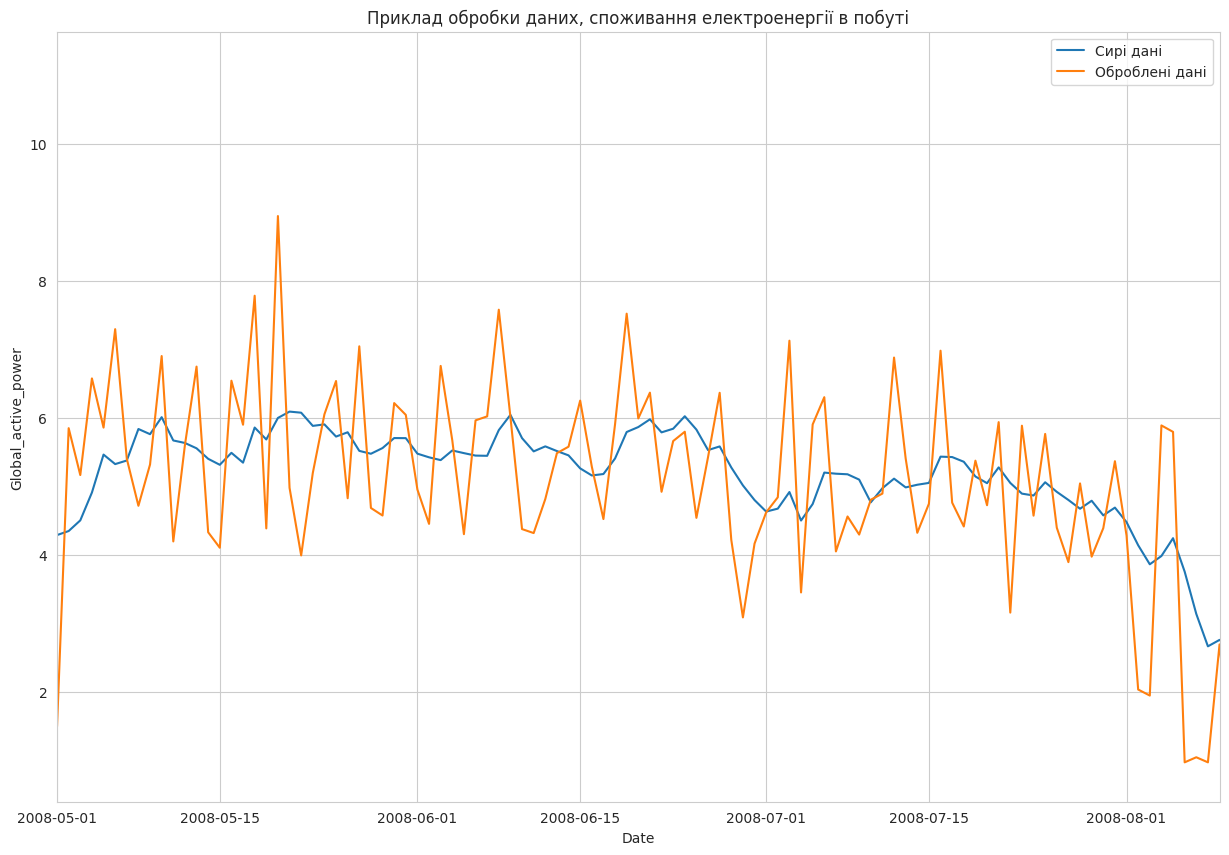

In [141]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    df.to_pandas(),
    x='Date',
    y='Global_active_power',
    label='Сирі дані'
)

sns.lineplot(df_2.to_pandas(), x="Date", y="Global_active_power", label='Оброблені дані')

plt.xlim((14_000, 14_100))

plt.legend()
plt.title('Приклад обробки даних, споживання електроенергії в побуті')
plt.show()

In [103]:
n = df.height

train_size = int(n * 0.7)
valid_size = int(n * 0.15)
test_size = n - train_size - valid_size

df = df.with_columns(
    [
        pl.when(pl.arange(0, n) < train_size)
        .then(pl.lit("train"))
        .when(pl.arange(0, n) < train_size + valid_size)
        .then(pl.lit("valid"))
        .otherwise(pl.lit("test"))
        .alias("split")
    ]
)

In [104]:
df.write_csv("/home/mpry/Projects/NULP/te/FractalNet_TimeSeries/data/processed/global_active_power_v2.csv")

In [62]:
df = (
    pl.scan_csv(
        "/home/mpry/Projects/NULP/te/FractalNet_TimeSeries/data/raw/spot.csv",
        ignore_errors=True,
    )
    .select(pl.col(["Date", "Close"]))
    .with_columns(pl.col("Date").str.to_datetime().dt.date(), pl.col("Close").cast(pl.Float32))
    .collect()
)

In [63]:
full_dates = (
    pl.date_range(
        start=df["Date"].min(), end=df["Date"].max(), interval="1d", eager=True
    )
    .alias("Date")
    .to_frame()
)

In [64]:
df = pl.concat(
    [
        df,
        full_dates.join(df, on="Date", how="anti")
    ],
    how='diagonal'
).sort('Date')

df

Date,Close
date,f32
2019-09-24,116.800003
2019-09-25,118.220001
2019-09-26,116.199997
2019-09-27,112.239998
2019-09-28,null
…,…
2024-09-19,360.220001
2024-09-20,365.170013
2024-09-21,null


In [67]:
df = df.with_columns(pl.col("Close").fill_null(strategy="forward"))

In [69]:
df = (
    df
        .sort("Date")
        .with_columns(pl.col("Close").rolling_mean(7))
        .filter(pl.col("Close").is_not_null())
)

In [71]:
n = df.height

train_size = int(n * 0.7)
valid_size = int(n * 0.15)
test_size = n - train_size - valid_size

df = df.with_columns(
    [
        pl.when(pl.arange(0, n) < train_size)
        .then(pl.lit("train"))
        .when(pl.arange(0, n) < train_size + valid_size)
        .then(pl.lit("valid"))
        .otherwise(pl.lit("test"))
        .alias("split")
    ]
)

In [74]:
df.write_csv(
    "/home/mpry/Projects/NULP/te/FractalNet_TimeSeries/data/processed/spot.csv"
)

In [80]:
pl.read_csv("/home/mpry/Projects/NULP/te/FractalNet_TimeSeries/data/processed/spot.csv")

Date,Close,split
str,f64,str
"""2019-09-30""",114.56286,"""train"""
"""2019-10-01""",113.95143,"""train"""
"""2019-10-02""",113.3343,"""train"""
"""2019-10-03""",113.13715,"""train"""
"""2019-10-04""",113.7343,"""train"""
…,…,…
"""2024-09-19""",342.69562,"""test"""
"""2024-09-20""",346.59134,"""test"""
"""2024-09-21""",350.48706,"""test"""


In [105]:
import polars as pl

df = (
    pl.scan_csv(
        "/home/mpry/Projects/NULP/te/FractalNet_TimeSeries/data/raw/Sunspots.csv",
        ignore_errors=True,
    )
    .select(pl.col(["Date", "Monthly Mean Total Sunspot Number"]))
    .with_columns(
        pl.col("Date").str.to_date().dt.truncate("1mo"),
        pl.col("Monthly Mean Total Sunspot Number").cast(pl.Float32),
    )
    .collect()
    .sort("Date")
    .with_columns(pl.col("Monthly Mean Total Sunspot Number").rolling_mean(12))
    .filter(pl.col("Monthly Mean Total Sunspot Number").is_not_null())
)

In [106]:
n = df.height

train_size = int(n * 0.7)
valid_size = int(n * 0.15)
test_size = n - train_size - valid_size

df = df.with_columns(
    [
        pl.when(pl.arange(0, n) < train_size)
        .then(pl.lit("train"))
        .when(pl.arange(0, n) < train_size + valid_size)
        .then(pl.lit("valid"))
        .otherwise(pl.lit("test"))
        .alias("split")
    ]
)

In [107]:
df.write_csv('../data/processed/sunspots_v2.csv')

In [89]:
import polars.selectors as cs

window_size = 3
predict_size = 1
input_column = "Monthly Mean Total Sunspot Number"

In [90]:
df = (
    pl.read_csv("../data/processed/sunspots_v2.csv")
    .with_columns(pl.col(input_column).cast(pl.Float32))
    .with_columns(
        pl.col(input_column).shift(i).alias(f"lag_{i}")
        for i in reversed(range(1, window_size + 1))
    )
    .drop_nulls()
    .with_columns(pl.concat_list(cs.starts_with("lag_")).alias("historical_data"))
    .with_columns(
        pl.col(input_column).shift(-i).alias(f"pr_lag_{i}")
        for i in range(0, predict_size)
    )
    .drop_nulls()
    .with_columns(pl.concat_list(cs.starts_with("pr_lag_")).alias("historical_data_predict"))
)

In [112]:
df = pl.read_csv(
    "/home/mpry/Projects/NULP/te/FractalNet_TimeSeries/data/processed/sunspots_v2.csv"
).with_columns(pl.col("Date").str.to_date())

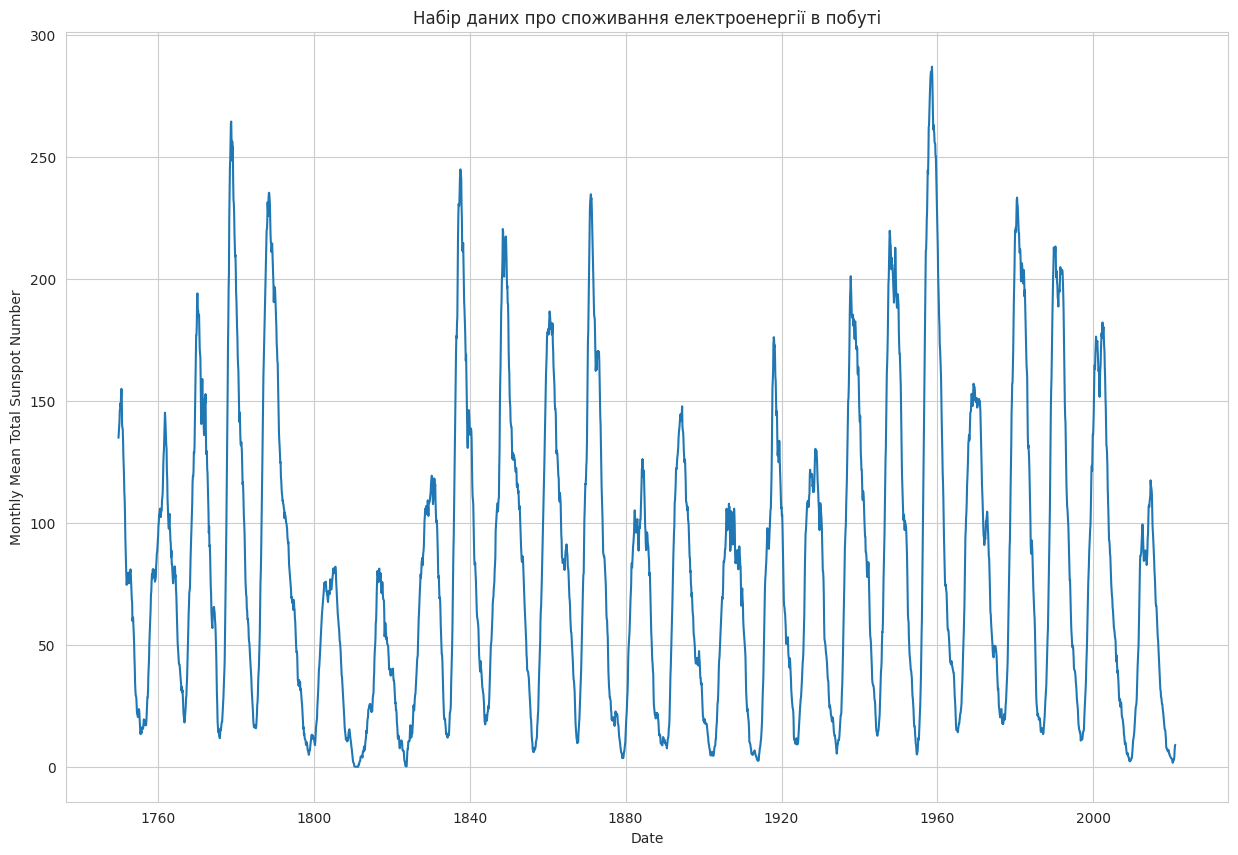

In [114]:
plt.figure(figsize=(15, 10))

sns.lineplot(df.to_pandas(), x="Date", y="Monthly Mean Total Sunspot Number")

plt.title('Набір даних про споживання електроенергії в побуті')

plt.show()